In [1]:
import json
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.stats import chi2
from tqdm import tqdm

from dataloader import FastTensorDataLoader

## Data Generation

In [2]:
def generate_samples(mean, cov, d, m, n):
    """
    Generate a list of samples drawn from a normal distribution (1D or multivariate).

    Args:
        mean (torch.Tensor): Mean of the normal distribution.
        cov (torch.Tensor): Covariance matrix.
        d (int): Number of dimensions for each sample.
        m (int): Number of samples to generate.
        n (int): Number of elements in each sample.

    Returns:
        list[torch.Tensor]: A list of `m` tensors.
            - For d > 1: Each tensor has shape (n, d).
            - For d = 1: Each tensor has shape (n, 1).
    """
    samples = []
    if mean.shape[0] != d or cov.shape != (d, d):
        raise ValueError("For d > 1, 'mean' must have shape (d,) and 'cov' must have shape (d, d).")
    distribution = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    for _ in range(m):
        sample = distribution.sample((n,))  # Generate n samples for each tensor
        samples.append(sample.clone())
    
    return samples

In [3]:
mu = torch.tensor([0.0, 0.0])
cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
m, n = 100, 1000
dim = mu.shape[-1]
samples = generate_samples(mu, cov, dim, m, n)

In [4]:
train_size = int(0.8 * m)
test_size = m - train_size

X = torch.stack(samples, dim=0)

X_train = X[:train_size]
X_test = X[train_size:]

loader_train = FastTensorDataLoader(X_train, batch_size=32, shuffle=False)
loader_test = FastTensorDataLoader(X_test, batch_size=32, shuffle=False)

## Model

In [5]:
class Gaussian(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian, self).__init__()
        torch.manual_seed(123)
        self.mu = nn.Parameter(torch.randn(dimensions, dtype=torch.float64))
        self.M = nn.Parameter(torch.randn(size=[dimensions, dimensions], dtype=torch.float64))
        A = torch.randn(dimensions, dimensions, dtype=torch.float64)
        self.M = nn.Parameter(torch.mm(A, A.T))    
        self.M.data += dimensions * torch.eye(dimensions, dtype=torch.float64)
        
    def forward(self, x):
        diff = x - self.mu
        return -0.5 * torch.einsum('bpi,ij,bpj->bp', diff, self.M, diff)

    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi
    
    def gaussian_psi(self, x):
        diff = x - self.mu
        return -torch.einsum('ij,bpj->bpi', self.M, diff)
    
    def gaussian_J(self, x, length):
        diff = x - self.mu
        trace_term = -torch.trace(self.M)
        quadratic_term = torch.einsum('bpi,ij,bpj->bp', diff, self.M @ self.M, diff)

        J_value = 0.5*quadratic_term + trace_term
        J_value = J_value.sum(dim=-1) / length

        return J_value.mean()
    
    def loss(self, x):
        length = len(x[0])
        psi_x = self.compute_psi(x).float()
        psi_x_real = self.gaussian_psi(x).float()
        if not torch.allclose(psi_x, psi_x_real, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {psi_x} \
                is different from the analytical solution {psi_x_real}"
                )

        norm_squared = (psi_x ** 2).sum(dim=-1) 

        divergence = 0
        for i in range(x.shape[-1]): 
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  
        
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)/length
        total_loss = total_loss.mean().float()

        J = self.gaussian_J(x, length).float()
        if not torch.allclose(total_loss, J, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {total_loss} \
                is different from the analytical solution {J}"
                )
        
        return total_loss, J
        

In [6]:
def optimize_theta_gaussian(
        loader_train, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_M=1e-4, 
    ):
    model = Gaussian(dim)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.M], "lr": learning_rate_M},
        ]
    )
    avg_epoch_losses = []
    avg_epoch_real_losses = []
    estimated_mus = []
    estimated_covs = []

    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    for _ in pbar:
        epoch_loss_sum = 0
        epoch_real_loss_sum = 0
        num_batches = len(loader_train)

        start_time = time.time()
        for X_batch in loader_train:
            optimizer.zero_grad()

            loss, real_loss = model.loss(X_batch[0])

            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            batch_real_loss = real_loss.item()
            epoch_loss_sum += batch_loss
            epoch_real_loss_sum += batch_real_loss

            estimated_mus.append(model.mu.detach().numpy().copy())
            estimated_covs.append(model.M.detach().numpy().copy())

        avg_loss = epoch_loss_sum / num_batches
        avg_real_loss = epoch_real_loss_sum / num_batches
        avg_epoch_losses.append(avg_loss)
        avg_epoch_real_losses.append(avg_real_loss)

        elapsed_time = time.time() - start_time
        pbar.set_postfix({
            "Train Loss": f"{avg_loss:.4f}",
            "Real Loss": f"{avg_real_loss:.4f}",
            "Time/Epoch": f"{elapsed_time:.2f}s"
        })
    
    return model, avg_epoch_losses, avg_epoch_real_losses, estimated_mus, estimated_covs


In [7]:
epochs = 100
model, losses, real_losses, estimated_mus, estimated_cov = optimize_theta_gaussian(
    loader_train, dim, num_epochs=epochs, learning_rate_mu=1e-3, learning_rate_M=1e-3,
    )

Training: 100%|██████████| 100/100 [00:08<00:00, 12.10epoch/s, Train Loss=-0.9964, Real Loss=-0.9964, Time/Epoch=0.08s]


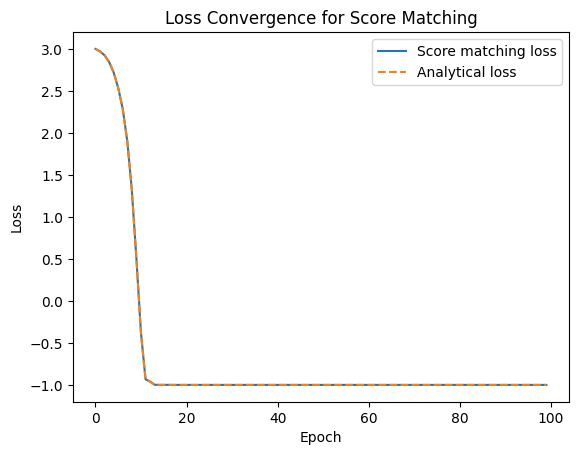

In [8]:
plt.plot(losses, label="Score matching loss")
plt.plot(real_losses, label="Analytical loss", linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()

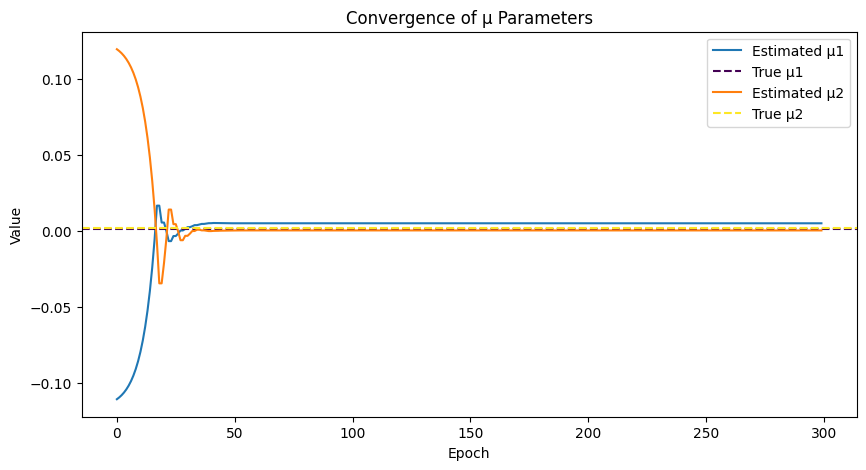

C:\Users\79217\AppData\Local\Temp\ipykernel_18464\4213944928.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  estimated_covs_array = np.array(torch.linalg.inv(torch.tensor(estimated_cov)))
C:\Users\79217\AppData\Local\Temp\ipykernel_18464\4213944928.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  estimated_covs_array = np.array(torch.linalg.inv(torch.tensor(estimated_cov)))


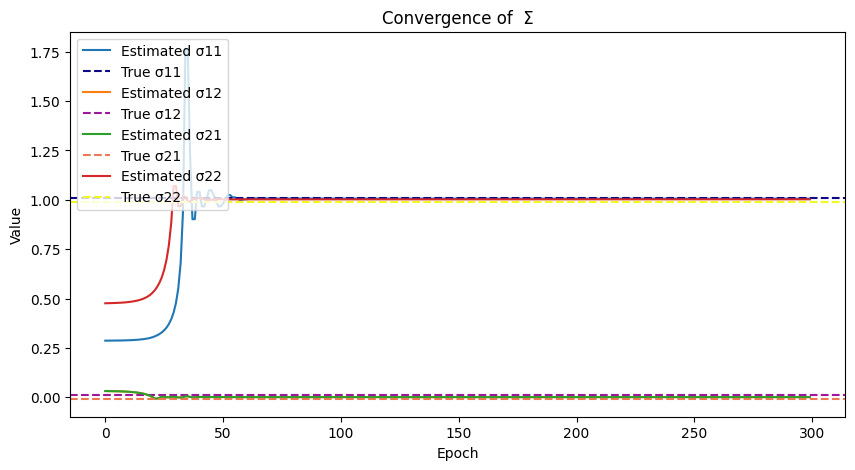

In [9]:
estimated_mus = np.array(estimated_mus)  # (epochs, d)
d = estimated_mus.shape[1]
colors_mu = plt.cm.viridis(np.linspace(0, 1, d))

plt.figure(figsize=(10, 5))
for i in range(d):
    plt.plot(estimated_mus[:, i], label=f"Estimated μ{i+1}")
    plt.axhline(
        mu[i] + 0.001 * (i + 1), 
        linestyle='--', color=colors_mu[i], label=f"True μ{i+1}")

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ Parameters')
plt.show()

estimated_covs_array = np.array(torch.linalg.inv(torch.tensor(estimated_cov)))
epochs, d, _ = estimated_covs_array.shape


colors_cov = plt.cm.plasma(np.linspace(0, 1, d * d))
color_map = np.reshape(colors_cov, (d, d, 4))
jitter = 0.01
plt.figure(figsize=(10, 5))
for i in range(d):
    for j in range(d):
        plt.plot(estimated_covs_array[:, i, j], label=f"Estimated σ{i+1}{j+1}")
        if i == j:  # Diagonal elements 
            plt.axhline(cov[i, j] + jitter * (1 if i % 2 == 0 else -1), linestyle='--', color=color_map[i, j], label=f"True σ{i+1}{j+1}")
        elif i < j:  # Off-diagonal unique pairs 
            plt.axhline(cov[i, j] + jitter, linestyle='--', color=color_map[i, j], label=f"True σ{i+1}{j+1}")
        else:  # Symmetric off-diagonal elements
            plt.axhline(cov[i, j] - jitter, linestyle='--', color=color_map[i, j], label=f"True σ{i+1}{j+1}")


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of  Σ')
plt.show()

In [10]:
print("Final estimated μ:", estimated_mus[-1])
print("True μ:", mu)
print("\nFinal estimated Σ:\n", torch.linalg.inv(torch.tensor(estimated_cov[-1])))
print("True Σ:\n", cov)

Final estimated μ: [0.00505853 0.00036832]
True μ: tensor([0., 0.])

Final estimated Σ:
 tensor([[1.0059e+00, 5.9578e-04],
        [5.9578e-04, 1.0027e+00]], dtype=torch.float64)
True Σ:
 tensor([[1., 0.],
        [0., 1.]])


## Statistical Significance

In [11]:
num_trials = 100
epochs = 100
learning_rate_mu = 1e-3
learning_rate_M = 1e-3

In [12]:
true_mu = []
true_cov = []
estimated_mu = []
estimated_cov = []

In [ ]:
json_file = f'data/trial_results_multivariate.json'

In [14]:
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        trial_results = json.load(f)
else:
    trial_results = []

n = 1000 # trials
m = 100 # samples per trial
dim = 2
num_points = 1000
for trial in tqdm(range(num_trials), desc="Running trials"):
    torch.seed()
    mu = torch.empty(2).uniform_(-2, 2)
    random_matrix = torch.rand(2, 2)
    cov = torch.mm(random_matrix.T, random_matrix)

    samples = generate_samples(mu, cov, dim, m, n)
    X = torch.stack(samples, dim=0)
    loader_train = FastTensorDataLoader(X, batch_size=32, shuffle=False)
    
    _, _, _, estimated_mu, estimated_cov = optimize_theta_gaussian(
        loader_train, dim, num_epochs=epochs,
        learning_rate_mu=learning_rate_mu,
        learning_rate_M=learning_rate_M)
    
    trial_result = {
        "trial": trial,
        "epochs": epochs,
        "lr_mu": learning_rate_mu,
        "lr_M": learning_rate_M,
        "true_mu": mu.tolist(),
        "true_cov": cov.tolist(),
        "estimated_mu": estimated_mu[-1].tolist(),
        "estimated_cov": torch.linalg.inv(torch.tensor(estimated_cov[-1])).tolist(),
    }
    trial_results.append(trial_result)
    
    with open(json_file, mode='w') as f:
        json.dump(trial_results, f, indent=4)

Running trials: 100%|██████████| 100/100 [16:31<00:00,  9.91s/it]


In [19]:
with open(json_file, mode='r') as f:
    trial_results = json.load(f)

true_mu = np.array([trial['true_mu'] for trial in trial_results])
true_cov = np.array([trial['true_cov'] for trial in trial_results])
estimated_mu = np.array([trial['estimated_mu'] for trial in trial_results])
estimated_cov = np.array([trial['estimated_cov'] for trial in trial_results])

In [20]:
p = 2  

# Compute Mahalanobis distances
D_squared = []
for i in range(num_trials):
    mean_diff = estimated_mu[i] - true_mu[i]
    cov_inv = np.linalg.inv(true_cov[i])
    D2 = np.dot(np.dot(mean_diff.T, cov_inv), mean_diff)  # Mahalanobis distance squared
    D_squared.append(D2)

D_squared = np.array(D_squared)

# Perform Chi-Squared Test
chi2_critical = chi2.ppf(0.95, df=p)  # Critical value for 95% confidence
significant_indices = np.where(D_squared > chi2_critical)[0]
significant_trials = np.sum(D_squared > chi2_critical)  # Count significant deviations
p_values = 1 - chi2.cdf(D_squared, df=p)  # Compute p-values for each trial

print(f"Number of significant trials: {significant_trials}/{num_trials}")
print(f"Mean p-value: {np.mean(p_values)}")

if significant_trials > 0:
    print("There are statistically significant deviations in some trials.")
    print("Significant trials details:")
    for idx in significant_indices:
        print(f"Trial {idx}:")
        print(f"  p-value = {p_values[idx]}")
        print(f"  True μ = {true_mu[idx]}")
        print(f"  Estimated μ = {estimated_mu[idx]}")
else:
    print("No statistically significant deviations detected.")

Number of significant trials: 0/100
Mean p-value: 0.9451993972979613
No statistically significant deviations detected.


In [21]:
df = p * (p + 1) // 2  # Degrees of freedom for covariance matrix
test_statistics = []
skipped_trials = 0

for i in range(num_trials):
    true_det = np.linalg.det(true_cov[i])
    pred_det = np.linalg.det(estimated_cov[i])
    
    # Skip invalid determinants
    if pred_det <= 0:
        skipped_trials += 1
        continue

    true_inv = np.linalg.inv(true_cov[i])
    trace_term = np.trace(np.dot(true_inv, estimated_cov[i]))
    log_det_term = np.log(true_det) - np.log(pred_det)
    
    # Compute test statistic (Lambda)
    test_stat = num_trials * (log_det_term + trace_term - p)
    test_statistics.append(test_stat)

test_statistics = np.array(test_statistics)
p_values = 1 - chi2.cdf(test_statistics, df=df)
significant_indices = np.where(p_values < 0.05)[0]
significant_trials = len(significant_indices)

# Print results
print(f"Number of significant trials: {significant_trials}/{num_trials}")
print(f"Mean p-value: {np.mean(p_values):.4f}")
print(f"Skipped trials due to invalid determinants: {skipped_trials}")

if significant_trials > 0:
    print("\nSignificant trials details:")
    for idx in significant_indices:
        print(f"Trial {idx}:")
        print(f"  p-value = {p_values[idx]:.4f}")
        print(f"  True Covariance Matrix:\n{true_cov[idx]}")
        print(f"  Estimated Covariance Matrix:\n{estimated_cov[idx]}")
else:
    print("\nNo significant differences detected in covariance matrices.")

Number of significant trials: 16/100
Mean p-value: 0.7679
Skipped trials due to invalid determinants: 2

Significant trials details:
Trial 1:
  p-value = 0.0000
  True Covariance Matrix:
[[0.35915464 0.62561476]
 [0.62561476 1.26816154]]
  Estimated Covariance Matrix:
[[0.71736636 1.33318556]
 [1.33318556 2.67393798]]
Trial 2:
  p-value = 0.0000
  True Covariance Matrix:
[[0.32822701 0.36852199]
 [0.36852199 0.41472885]]
  Estimated Covariance Matrix:
[[0.82637463 0.92777158]
 [0.92777158 1.04356988]]
Trial 22:
  p-value = 0.0000
  True Covariance Matrix:
[[0.99847698 0.64707917]
 [0.64707917 0.52393013]]
  Estimated Covariance Matrix:
[[1.01993844 0.6603514 ]
 [0.6603514  0.53446291]]
Trial 34:
  p-value = 0.0000
  True Covariance Matrix:
[[1.04576182 0.89872426]
 [0.89872426 0.82705885]]
  Estimated Covariance Matrix:
[[1.071818   0.92186761]
 [0.92186761 0.84891797]]
Trial 46:
  p-value = 0.0000
  True Covariance Matrix:
[[0.88395798 0.39642143]
 [0.39642143 0.33551022]]
  Estimated

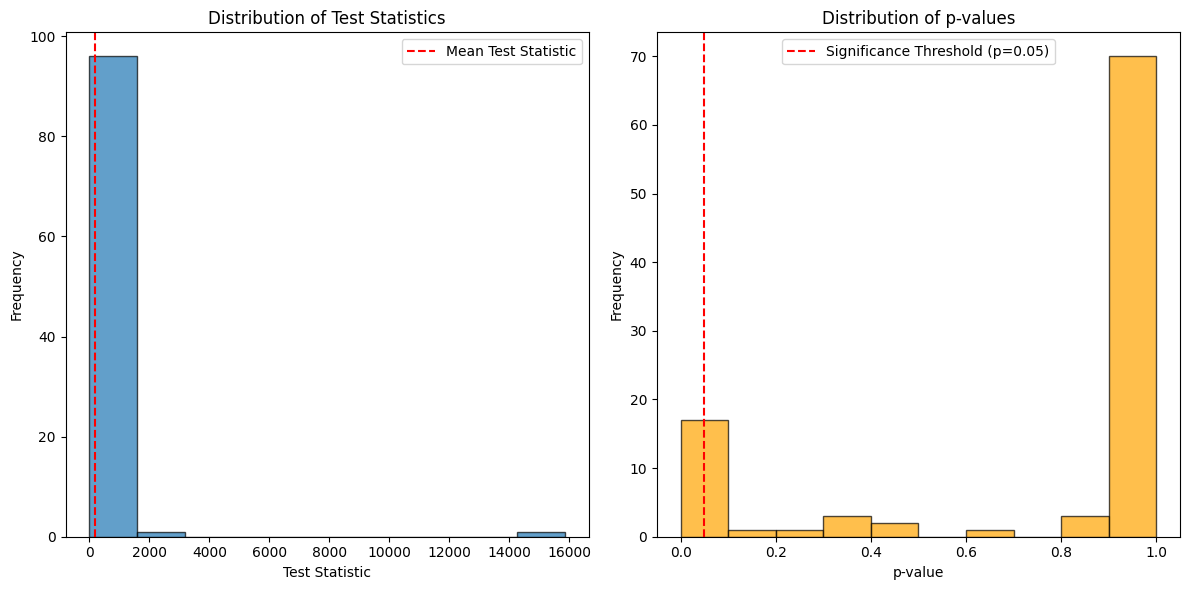

In [23]:
# Plotting
plt.figure(figsize=(12, 6))

# Distribution of Test Statistics
plt.subplot(1, 2, 1)
plt.hist(test_statistics, alpha=0.7, edgecolor='k')
plt.axvline(np.mean(test_statistics), color='red', linestyle='--', label='Mean Test Statistic')
plt.title('Distribution of Test Statistics')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.legend()

# Distribution of p-values
plt.subplot(1, 2, 2)
plt.hist(p_values, alpha=0.7, edgecolor='k', color='orange')
plt.axvline(0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()
